In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.cm import rainbow
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
#计算程序运行时间
import timeit

In [2]:
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体设置-黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
sns.set(font='SimHei')            # 解决Seaborn中文显示问题

In [3]:
#降维方法
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import FastICA 

In [4]:
#机器学习方法
#网格搜索
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

## 一、数据导入
    除可能的重复值后抽取10条随机数据。当前数据不存在需要编码的变量九个变量分别为：妊娠次数，血糖，血压，皮肤厚度，胰岛素，BMI，糖尿病遗传函数，年龄，结果

In [6]:
data=pd.read_csv('E:/研一上学期课程作业及教材ppt/数据挖掘/diabetes.csv')
data.duplicated()
data.sample(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
570,3,78,70,0,0,32.5,0.270,39,0
361,5,158,70,0,0,29.8,0.207,63,0
316,3,99,80,11,64,19.3,0.284,30,0
592,3,132,80,0,0,34.4,0.402,44,1
751,1,121,78,39,74,39.0,0.261,28,0
416,1,97,68,21,0,27.2,1.095,22,0
77,5,95,72,33,0,37.7,0.370,27,0
699,4,118,70,0,0,44.5,0.904,26,0
111,8,155,62,26,495,34.0,0.543,46,1
202,0,108,68,20,0,27.3,0.787,32,0


In [7]:
#Outcome列是我们预测的目标，单独抽出，首先对其它变量进行处理
Y=data['Outcome']
X=data.drop(['Outcome'],axis=1)

In [8]:
#数据特征标准化
scaler = StandardScaler()
X=scaler.fit_transform(X)

## 二、 数据处理
    对变量绘制相关关系图，发现变量间的相关性不强，可能无法进行很好的降维，操作后发现，PCA和ICA方法都无法将数据很好地分类。如果强行提取
    其中较少的几个因子，降低解释性的同时也无法达到很好的效果。所以模型用全部的自变量来训练

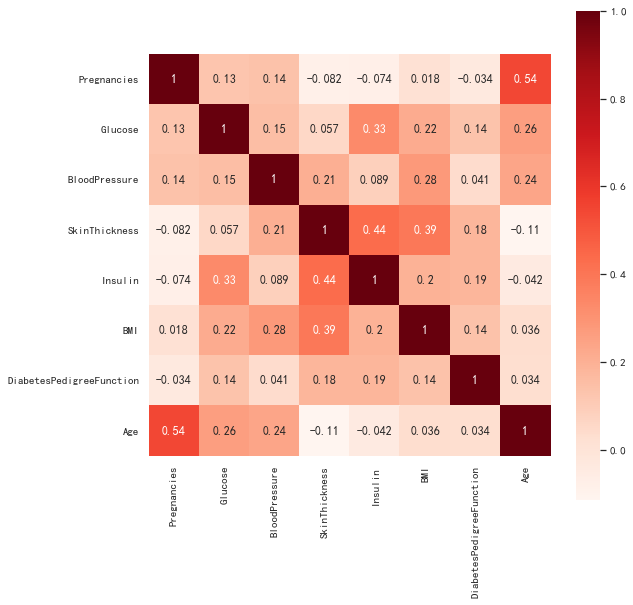

In [9]:
X=pd.DataFrame(X,columns=data.columns[0:8])
XCorr = X.corr()
plt.subplots(figsize=(9, 9)) # 设置画面大小
sns.heatmap(XCorr, annot=True, vmax=1, square=True, cmap="Reds")

In [10]:
#主成分降维
pca=PCA(n_components=2)
X_pca=pca.fit_transform(X)
#ICA降维
ICA=FastICA(n_components=2)
X_ICA=ICA.fit_transform(X)
#随机森林分析各变量的重要性
model_R = RandomForestRegressor(random_state=1, max_depth=10)
model_R.fit(X,Y)
features = X.columns
importances = model_R.feature_importances_
indices = np.argsort(importances[0:8])  # top 8(全部变量的重要程度)

<Figure size 432x288 with 0 Axes>

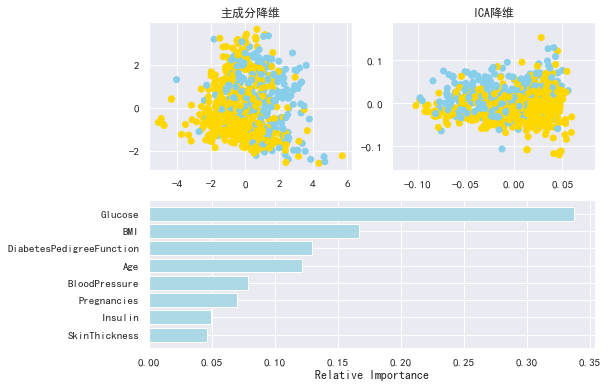

In [11]:
#改变散点图的颜色
set_color={0:'gold',1:'skyblue'}
Color=Y.replace(set_color)
#绘制多张图
plt.figure(1)
plt.figure(figsize=[8,6])
#第一行第一列图形
plt.subplot(2,2,1)
plt.scatter(X_pca[:, 0], X_pca[:, 1],c=Color)
plt.title('主成分降维')
#第一行第二列图形
plt.subplot(2,2,2)
plt.scatter(X_ICA[:, 0], X_ICA[:, 1],c=Color)
plt.title('ICA降维')
#第二行只放一张图形，重新分配
plt.subplot(2,1,2)
plt.barh(range(len(indices)), importances[indices], color='lightblue', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## 三、模型训练
    将数据划分为训练集和测试集，因为样本中结果为'0'和为‘1’的样本分布不均，所以对数据进行下采样。然后用于模型训练，并对各默认模型的准确率画出柱状图

In [12]:
#对所给数据划分训练集和测试集
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=33)
y_train.value_counts()

0    354
1    183
Name: Outcome, dtype: int64

In [13]:
#发现数据不同类别分布不均，为了调整数据，进行下采样
y_train_1=y_train[y_train==1]
y_train_0=y_train[y_train==0]
num=y_train_1.size
#对结果为0的样本进行下采样
y_train_0=y_train_0.sample(num)
#按照与y相同的索引选择下采样后的X_train
X_train_0=X_train[X_train.index.isin(list(y_train_0.index))]
X_train_1=X_train[X_train.index.isin(list(y_train_1.index))]
#合并
y_train=pd.merge(y_train_0,y_train_1,how='outer')
X_train=pd.merge(X_train_0,X_train_1,how='outer')

In [14]:
#XGboost算法
xgb_class= XGBClassifier()
xgb_class.fit(X_train,y_train)
y_predict=xgb_class.predict(X_test)
print (classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.82      0.73      0.77       146
           1       0.61      0.73      0.66        85

    accuracy                           0.73       231
   macro avg       0.71      0.73      0.72       231
weighted avg       0.74      0.73      0.73       231



In [15]:
#输出不同模型的正确率
model=[]
columns_name=[]
#xgboost
model.append(XGBClassifier())
columns_name.append('XGB')
#Adaboost
model.append(AdaBoostClassifier())
columns_name.append('Adaboost')
#KNN分类
model.append(KNeighborsClassifier())
columns_name.append('KNN')
#SVM分类
model.append(SVC())
columns_name.append('SVM')
#GBDT分类
model.append(GradientBoostingClassifier())
columns_name.append('GBDT')
#伯努利分类
model.append(BernoulliNB())
columns_name.append('NB')
#线性回归
model.append(LogisticRegression())
columns_name.append('逻辑回归')
#线性判别
model.append(LinearDiscriminantAnalysis())
columns_name.append('LDA')
#神经网络
model.append(MLPClassifier())
columns_name.append('神经网络')

In [16]:
#记录准确率
MP=[]
def Model_precision(model):
    model.fit(X_train,y_train)
    y_predict=model.predict(X_test)
    print (f'模型的准确率为:{model.score(X_test,y_test)}')
    print (f'模型对训练集的准确率为:{model.score(X_train,y_train)}')
    MP.append(model.score(X_test,y_test))
    #print (classification_report(y_test, y_predict))

In [17]:
for i in range(len(model)):
    print(f'{columns_name[i]}的准确率报告：')
    Model_precision(model[i])

XGB的准确率报告：
模型的准确率为:0.7272727272727273
模型对训练集的准确率为:1.0
Adaboost的准确率报告：
模型的准确率为:0.7056277056277056
模型对训练集的准确率为:0.8688524590163934
KNN的准确率报告：
模型的准确率为:0.7402597402597403
模型对训练集的准确率为:0.8142076502732241
SVM的准确率报告：
模型的准确率为:0.7705627705627706
模型对训练集的准确率为:0.825136612021858
GBDT的准确率报告：
模型的准确率为:0.7272727272727273
模型对训练集的准确率为:0.9672131147540983
NB的准确率报告：
模型的准确率为:0.7056277056277056
模型对训练集的准确率为:0.7240437158469946
逻辑回归的准确率报告：
模型的准确率为:0.7792207792207793
模型对训练集的准确率为:0.7704918032786885
LDA的准确率报告：
模型的准确率为:0.7705627705627706
模型对训练集的准确率为:0.7595628415300546
神经网络的准确率报告：
模型的准确率为:0.7445887445887446
模型对训练集的准确率为:0.8387978142076503


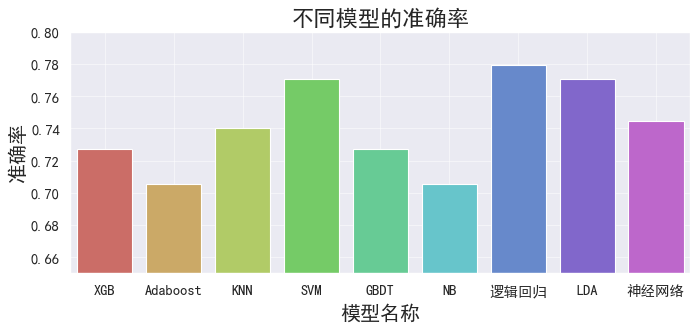

In [18]:
plt.figure(figsize=(10,4),dpi=80)
pal = sns.color_palette("hls", 10)       # 使用seaborn调色板
sns.barplot(x=columns_name,y=MP,palette=pal)   # 绘制条形图
#调整y轴的范围
plt.ylim(0.65,0.8)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('模型名称', size=18)
plt.ylabel('准确率', size=18)
plt.title('不同模型的准确率', size=20)
plt.grid(alpha=0.5)
plt.show()

In [23]:
#对神经网络模型进行参数调整
param_test1={'learning_rate_init':[0.001,0.01,0.1,1,10],'solver':['adam','SGD'],'validation_fraction':[0.1,0.2,0.3], 'warm_start':[False,True]}
gsearch1=GridSearchCV(estimator=MLPClassifier(),param_grid=param_test1, scoring='roc_auc',iid=False,cv=5)
gsearch1.fit(X_train,y_train)
print(gsearch1.best_params_,gsearch1.best_estimator_)
MLP_class=gsearch1.best_estimator_
print(MLP_class.score(X_train,y_train))
print(MLP_class.score(X_test,y_test))

{'learning_rate_init': 0.001, 'solver': 'adam', 'validation_fraction': 0.3, 'warm_start': True} MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.3, verbose=False,
              warm_start=True)
0.8415300546448088
0.7662337662337663


调整参数后得到最终的神经网络模型,比默认模型提高了2%的准确度
    MLPClassifier('learning_rate_init': 0.001, 'solver': 'adam', 'validation_fraction': 0.3, 'warm_start': True} MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.3, verbose=False,
              warm_start=True)